# [Exploration 19] BERT - 인간보다 퀴즈를 잘 푸는 인공지능

# BERT Pretrained model을 활용하여  KorQuAD 진행

아래 사진은 BERT의 모델구조를 나타낸 이미지이다. Transfomer 모델의 Encoder를 가지고와서 사용하였으며, 출력 모델에는 Mask LM과 NSP라는 방법을 통해 Decoder의 부제를 해결한다.

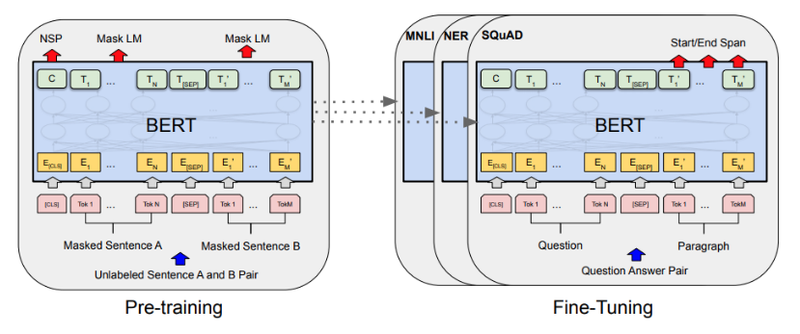

### Mask LM

어떤 한 문장이 있다고 가정했을 때, 문장 안에서 빈칸을 두고(마스크를 씌우고) 그 사이를 맞출 수 있도록 하는 언어모델이다. 빈칸에 알맞는 말을 찾을 수 있도록 엄청난 양의 데이터를 학습킨다.

### Next Sentence Prediction

**Next Sentence Prediction**, 말 그대로 다음에 올 문장을 예측하는 문장이다. 두 문장 사이가 잘 이어지는지를 확인하는 모델이다. 구체적인 모델 구조는 아래 이미지와 같이 구성되어있다.

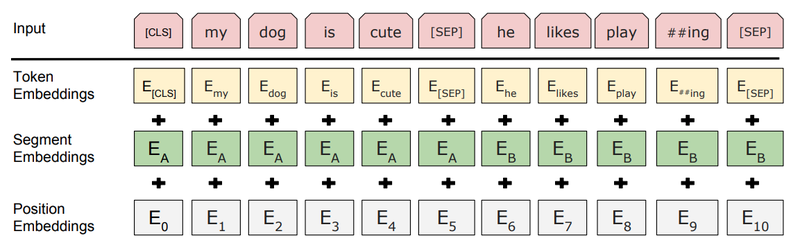

### Token Embedding

BERT 모델에서는 텍스트의 토크나이저로 Word Piece model이라는 subword tokenizer를 사용한다. 문자 단위뿐만 아니라 자주 등장하는 단어까지도 subword로 임베딩 해준다.

### Segment Embedding

기존 transfomer에는 없다는 임베딩이라고 한다. 각각의 단어가 어느 문장에 포함되는지 역할을 규정?하는 임베딩 방법이라고 한다.

### Position Embedding

Trainformer에서 사용된 임베딩와 동일한 positioning embedding이다.

## STEP 1. pretrained model 로딩하기

In [79]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [69]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_37 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


Pretrained BERT 모델을 불러왔다.

## STEP 2. pretrained model finetune 하기


KorQuAD 모델에 맞게 학습시키도록 한다.

In [71]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
start_loss1 = []
end_loss1 = []
start_acc1 = []
end_acc1 = []


for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        start_loss1.append(start_loss)
        end_loss1.append(end_loss)
        start_acc1.append(start_acc)
        end_acc1.append(end_acc)
        print(f'save best model')
    else:
        patience += 1
        start_loss1.append(start_loss)
        end_loss1.append(end_loss)
        start_acc1.append(start_acc)
        end_acc1.append(end_acc)
    if 5 <= patience:
        print(f'early stopping')
        break

0it [00:00, ?it/s]

eval 0 >> loss: 3.5913, 4.1293, acc: 0.1689, 0.1538
save best model


0it [00:00, ?it/s]

eval 1 >> loss: 3.8372, 4.3705, acc: 0.1675, 0.1510


0it [00:00, ?it/s]

eval 2 >> loss: 3.9780, 4.5130, acc: 0.1562, 0.1483


0it [00:00, ?it/s]

eval 3 >> loss: 4.4719, 5.2066, acc: 0.1517, 0.1440


0it [00:00, ?it/s]

eval 4 >> loss: 4.7019, 5.2282, acc: 0.1473, 0.1357


0it [00:00, ?it/s]

eval 5 >> loss: 5.1487, 5.9533, acc: 0.1429, 0.1404
early stopping


 이미 pre_trained모델이라 너무 많이 학습은 진행하지 않고 early stop이 되었다.   
 그치만 정확도와 로스는 상당히 낮은 수치를 보인다.   
 결과를 시행해보고 다시 분석해보겠다.

## STEP 3. Inference 수행하기


In [73]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [74]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

52
질문 :  전통 신학계의 근본주의적 시작을 여전히 받아들여 노아의 방주를 역사적 사실로 인식하는 집단은?
지문 :  역사학과 과학이 발달하지 않았던 과거 전통 신학계에서는 근본주의적 시각을 받아들여 노아의 방주를 역사적 사실로 기술하려 했으며, 이러한 관점은 아직도 과학과 역사학에 어두운 보수적 근본주의계열의 개신교에서만 받아들여지고 있다. 하지만 역사학과 과학의 발달로 인해, 노아의 방주의 실존에 대한 의문이 제기가 되고, 세계적 홍수가 존재할 수 없음이 밝혀짐에 따라 현대 신학계에서는 비록 노아의 홍수가 과학적으로 실존하지는 않았지만 그 자체의 의미는 신학적으로 매우 중요하며, 이에 대한 해석은 다양하게 이루어지고 있으며, 대부분의 기독교(가톨릭, 개신교를 포함한 대부분)에서는 노아의 방주는 상징적 의미로 받아들여진다. 그러므로 과학과는 상관없이 신학적으로 노아의 방주 자체의 의미는 중요하게 해석된다고 한다
정답 :  보수적 근본주의계열의 개신교
예측 :  어두운 보수적 근본주의계열의 개신교에서만 받아들여지고 있다. 하지만 역사학과 과학의 발달로 인해, 노아의 방주의 실존에 대한 의문이 제기가 되고, 세계적 홍수가 존재할 수 없음이 밝혀짐에 따라 현대 신학 

65
질문 :  1955년 목재의 파편을 발견한 프랑스의 탐험가 이름은?
지문 :  일반적으로 터키의 아라랏 산의 경우, 실제 성경 속에 등장하는 아라랏 산은 지금 아라랏이라 불리는 하나의 산이 아니라 당시 아라랏이라고 불리던 광대한 지역의 산들을 모두 가리키는 표현이라는 주장도 나와 있으며, 또한 목재로 만들어진 방주가 현재까지 남아있을 수는 없다는 비판도 받고 있다. 예를 들어, 1955년 프랑스의 탐험가인 Fernand Navarra가 발견한 목재 파편의 경우, 스페인의 임업 연구소에서 목재의 특성을 토대로 5000년 전의 것이라고 밝히긴 했으나 그 신빙성에 문제점이 있었고 후에 방사성 동위원소 측정법 등의 첨단 과학의 도움을 받은 5개 연구소에서 모두 기원 이후의 시기로 연대를 측정했다.

학습 진행 결과를 보면 좋지않은 loss와 acc값이 나왔음에도 불구하고 아주 정확한 답변을 예측하고 있다.

## STEP 4. 학습 경과 시각화 비교분석

In [77]:
start_acc, end_acc

(<tf.Tensor: shape=(), dtype=float32, numpy=0.1429073>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14044943>)

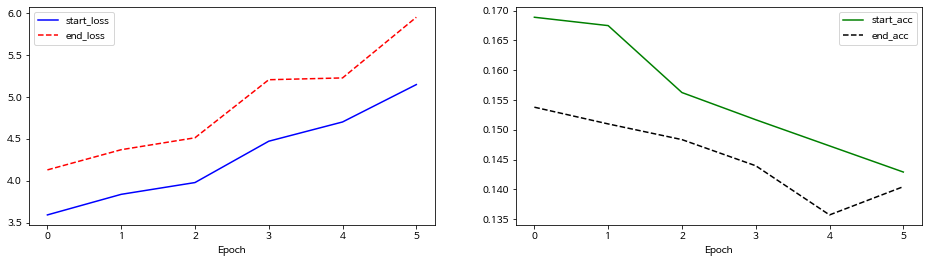

In [78]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(start_loss1, 'b-', label='start_loss')
plt.plot(end_loss1, 'r--', label='end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(start_acc1, 'g-', label='start_acc')
plt.plot(end_acc1, 'k--', label='end_acc')
plt.xlabel('Epoch')
plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(history.history['end_accuracy'], 'b-', label='end_accuracy')
# plt.plot(history.history['val_end_accuracy'], 'g--', label='val_end_accuracy')
# plt.xlabel('Epoch')
# plt.legend()

plt.show()

### ⬆️ < BERT Pre-trained model > ⬆️

메모리 문제로 버트를 사용하기 전의 트레이닝값들을 불러올 수 없어 이미지로 대체하겠다.   
   
### ⬇️ < 10 Epochs training model > ⬇️
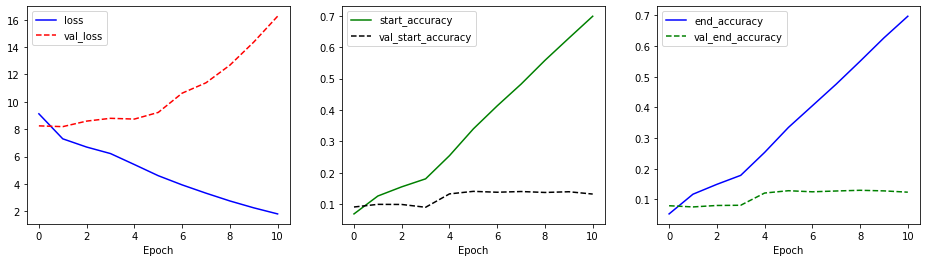

먼저, BERT모델을 확인해보면, 학습을 진행할 수록 로스와 정확도가 점점 감소하는 그래프가 보인다. 그리고 이런 상황이 5에폭동안 지속되자 얼리스탑 된 것으로 보인다. (학습 코드에서 5번으로 설정해뒀음)   
   
   
다음으로 이미 학습된 모델을 가져오지 않고 학습을 시킨 경우에는 일정값 이상으로 전혀 학습이 되지 않고 있음을 보인다.   
   
   
사실 BERT의 학습모델을 가지고 와서 학습을 시킬 때에는 더 좋은 결과값을 보이지 않을까 기대했었는데 의외의 그래프가 그려지고 있어 아쉽다. 원인은 잘 모르겠지만 결과값을 본다면 정말 인간보다 뛰어난 KorQuAD를 보여주고 있다.

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- BERT 모델에 들어가는 각 과정과 특징을 이해하는데 어려움이 있었다.   
- 기존의 Transformer 등과의 결합을 이해하는데 시간이 걸렸다.

   
## 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
- NLP 분야에서 다양한 모델이 나오고 있지만, BERT는 지금까지 배운 모델중 가장 성능이 뛰어난 모델이라는 생각이 든다. 그만큼 앞으로 많이 쓰일 것으로 예상되어 더 깊은 공부를 해야겠다는 생각이 들었다.


## 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
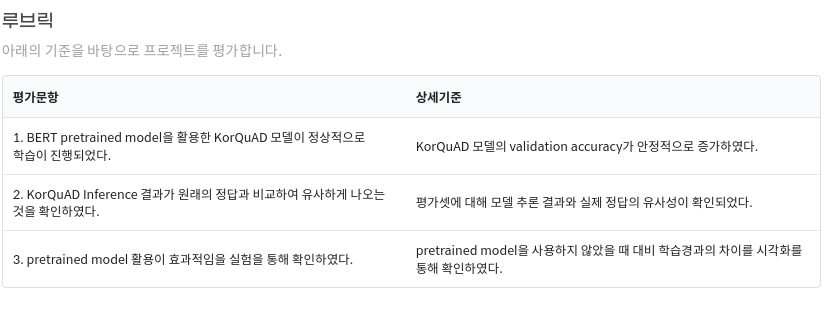   
- Validation이 나름 안정적으로 증가하였다.   
- 정답이 굉장히 유사하다.   
- 사전학습모델의 시각화를 하였다.

   
## 4. **자기 다짐**   
- 자연어 처리 분야에서 사용되는 고성능 모델로서 BERT에 대해 알아보았다. 결론적으로는 기존의 RNN, LSTM, Transformer등의 이전 모델에 대한 구조와 특징에 대한 이해가 없었더라면 이번 프로젝트를 진행하기 어려웠을 수도 있을것 같다.   
- 기회가 된다면 앞선 모델들에 대한 복습과 BERT 모델에 대한 디테일한 공부를 해보고 싶다.